### Why LangGraph over LangChain ?
* In langchain experession language we cannot make cycles. We can only have acyclic graphs. It has restrict the certain flow. We cannot come back to original node that we started from and start the process all over again.
* In LangGraph , we can implement cycles. So we can build very complex agents that have certain amount of freedom that we are not used to before. Now we can define the flow of our program and we can blend in with line graph. These cycels gives us freedom to redirect the agent wherever is necessary.


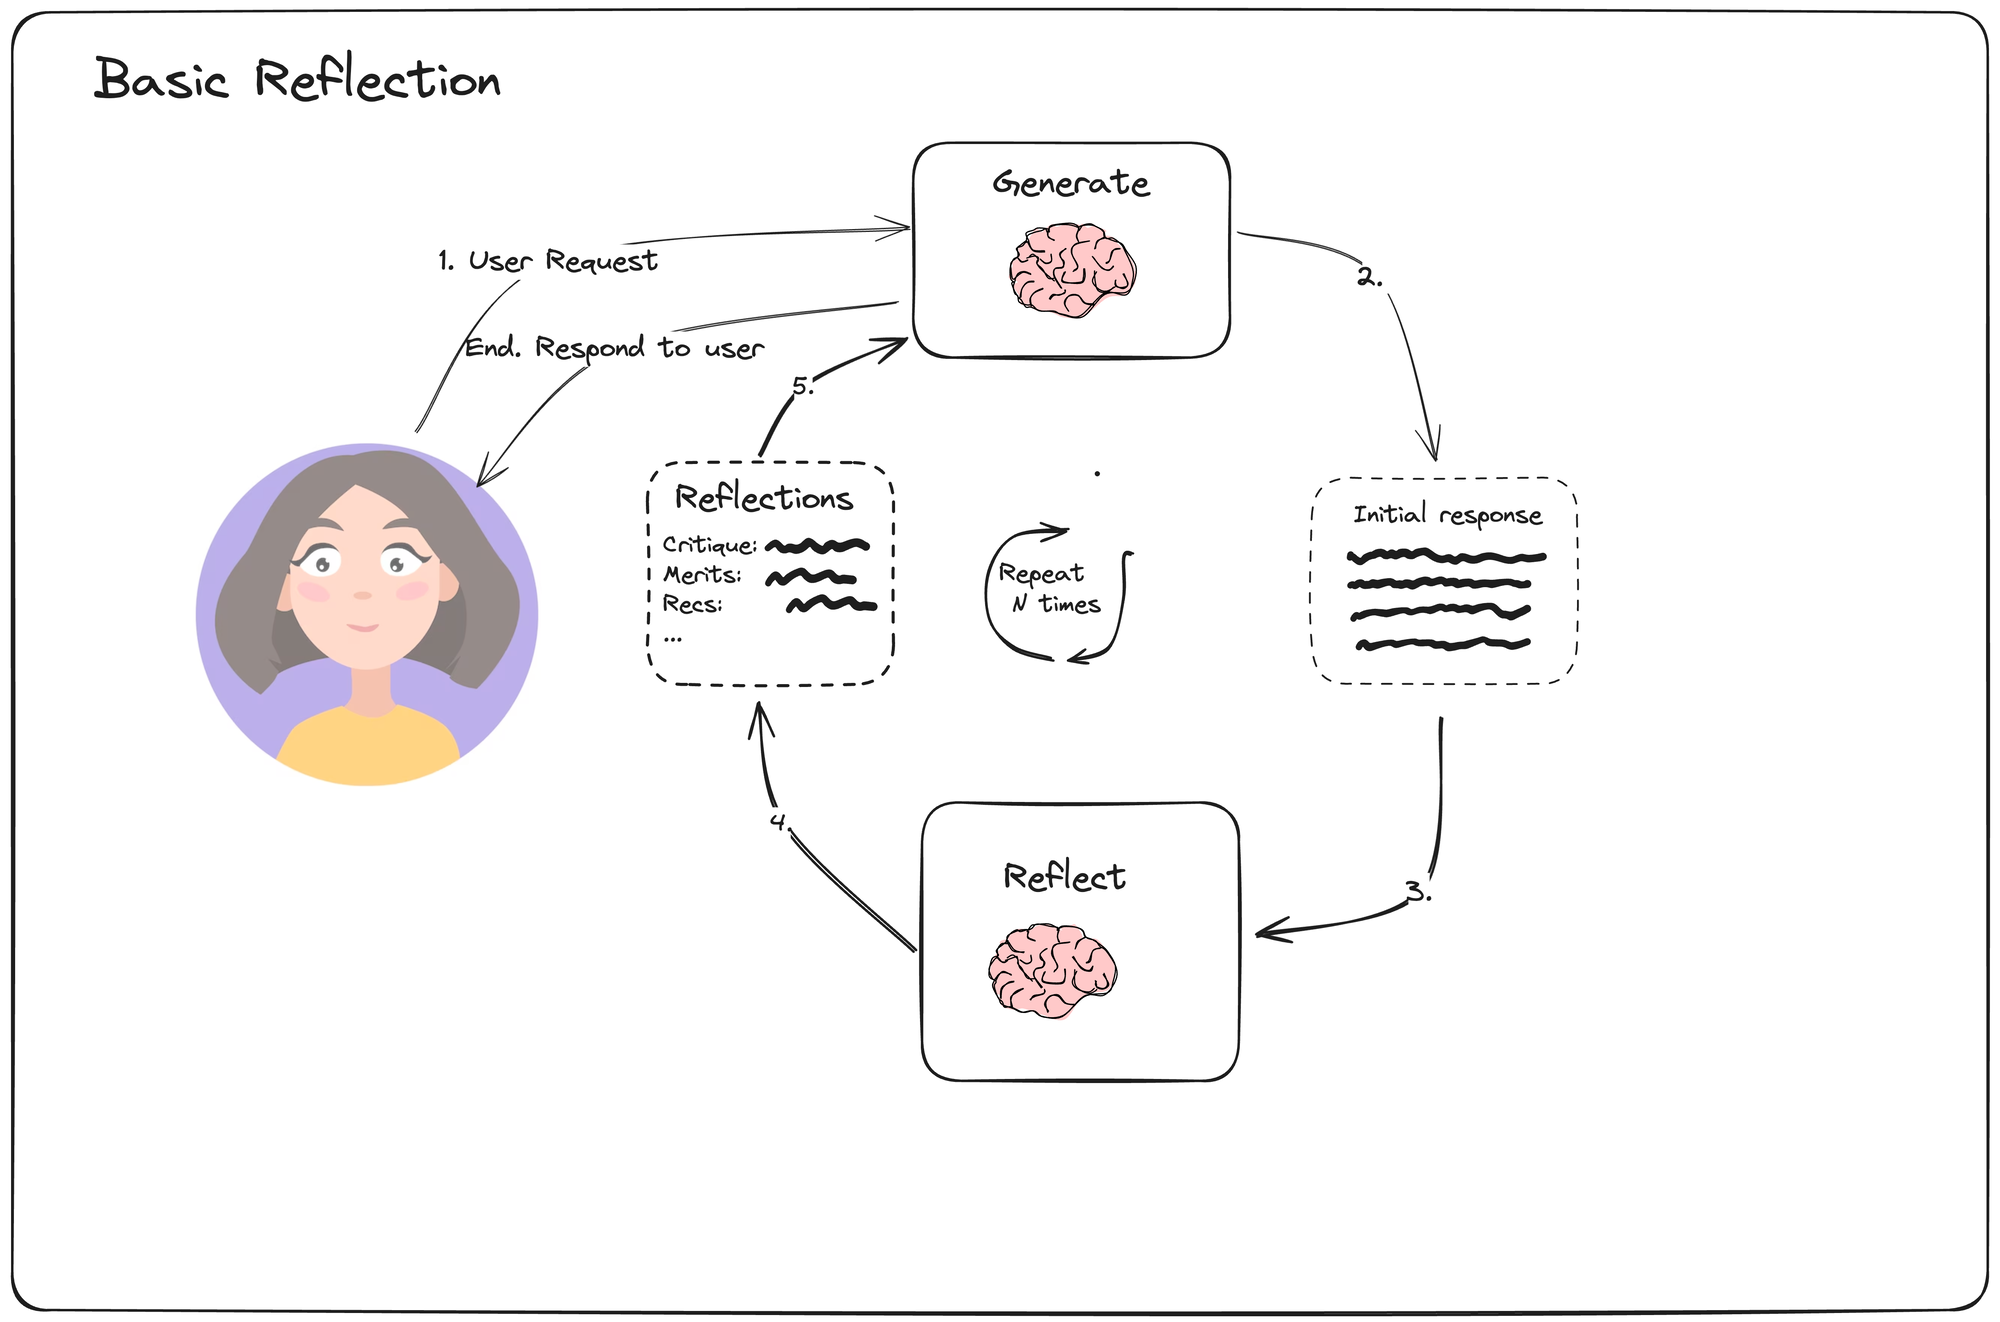

* The entire flow of agent can be expressed as a graph or a graph with cycles.
*  

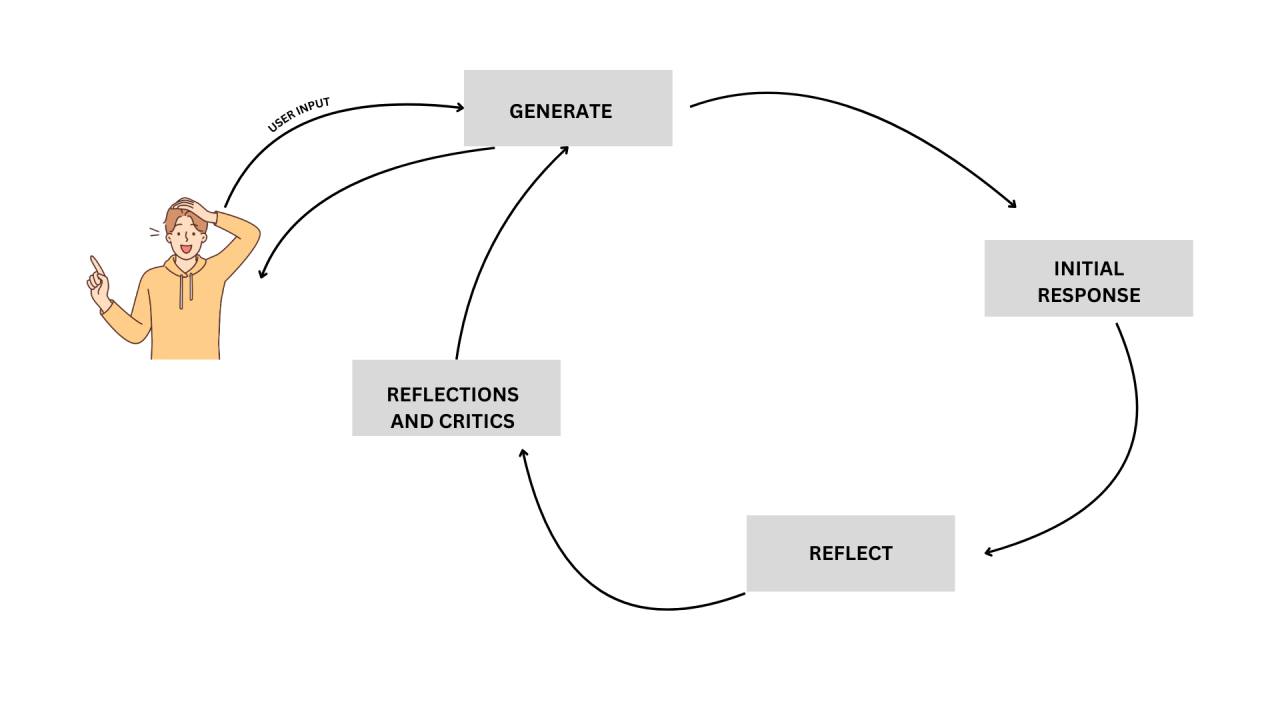

### Graphs 
- Non linear abstract data strcutures
- Use to model pair wise relationship b/w objects.


- Two concepts :
    1. Vertices or Nodes - Fundamental unit representing points or entities
    2. Edges - This connects two nodes/vertices.
- Edges can be directed or non directed, means can have direction or no direction.


- Types of Graphs:
    1. Simple Graphs - Only two vertices and one edge.
    2. Multigraph - Multiple vertices.
    3. Weighted Graph - Edges carries weights.
    4. Directed Graph - Edges have direction 
    5. DAG - Directed Acyclic Graph - Directed graphs with no cycles.


### Some Concepts :
- States Machine
    - Model of computation that represents the behavior of system.

- States
    - Different condition or model of operation that a system can be in. Only one state is active at a time.

- Transition 
    - Defines how system moves from one state to other.

- Input / Events 
    - Triggers transition between two states.

- Actions 
    - Activities that occur during transition or while in specific state

### Components of LangGraph
- Nodes 
    - Nodes Nodes represent individual components or agents within an AI workflow and act as the building      blocks executing computations. They can be LLMs or Python code.

- Edges
    - Edges connect nodes and dictate the graph's execution flow

- Conditional Edges
    - Conditional edges in LangGraph are edges that determine the next node(s) to execute based on a routing function evaluated after a node runs.
    - Instead of always going from one node to a fixed next node, conditional edges call a function that inspects the current graph state and returns the name(s) of the next node(s) to execute. This allows dynamic routing in the graph depending on runtime conditions or data.
    - You define conditional edges by specifying a node and a routing function with ```add_conditional_edges```.

    ``` graph.add_conditional_edges("node_a", routing_function, {True: "node_b", False: "node_c"}) ```

- Here, after executing node_a, the ```routing_function ``` decides whether to route to node_b or node_c based on the state



### State Management

- State is a simply dict , which consists of important params which we need to track of. Ex - storing chat history.

- In LangGraph, state management revolves around two key concepts: the state schema and reducers.
    - State Schema 
    - Reducer

- State Schema defines the type of objects that is given to each graph's node.
- Reducers defines how to apply Node outputs to the current State.


#### Nodes
The input to nodes in LangGraph is the current state of the graph at the time the node executes. This state is a structured data object-typically a Python dictionary, a TypedDict, or a Pydantic model-that holds all relevant information the node needs to perform its computation.

```
Nodes get a "state" as input.
Think of the state as a box that holds all the information the node needs to do its job.
```

``` The state is like a dictionary (key-value pairs).```









```
Each node reads this state when it runs.
It looks inside the box, uses the information it needs, and then updates the box with new information.
```

```
Nodes return updates, not the whole state.
For example, a node might add an "answer": "I'm fine!" to the box.
```

The graph keeps track of the whole state and passes it to the next node.

``` 
Summary : 
- Input to a node = the current state (all info so far).
- Node reads the state and returns updates.
- Graph updates the state and passes it to the next node.

```

In [1]:
from typing_extensions import TypedDict
from langgraph.graph import StateGraph, START, END

class InputState(TypedDict):
    question: str

class OutputState(TypedDict):
    answer: str

class OverallState(InputState, OutputState):
    pass

def answer_node(state: InputState):
    return {"answer": "bye", "question": state["question"]}

builder = StateGraph(OverallState, input=InputState, output=OutputState)
builder.add_node(answer_node)
builder.add_edge(START, "answer_node")
builder.add_edge("answer_node", END)
graph = builder.compile()

print(graph.invoke({"question": "hi"}))  # Output: {'answer': 'bye'}


{'answer': 'bye'}


- The input to answer_node is a box with the question inside.
- The node reads the question and returns an answer.
- The graph updates the box with the answer and sends it forward.


```def answer_node(state):
    # state has a "question"
    question = state["question"]
    # node creates an answer
    return {"answer": "I'm fine!"}```




### Important Keys :
#### Cycles 
    - Cycles in LangGraph allow the workflow to loop back to previous nodes instead of moving strictly forward. This means the graph can revisit steps multiple times, enabling iterative processes, retries, or multi-turn conversations.

* Why are cycles important?
    - They are essential for agentic architectures where the system needs to refine answers, ask clarifying questions, or perform repeated actions based on updated information.

* How does LangGraph support cycles?
    - You can define edges that create loops in the graph, allowing the execution flow to cycle back to earlier nodes as needed. This supports complex workflows like autonomous agents or chatbots that interact over multiple turns

#### Human-in-the-Loop (HIL)
* What is human-in-the-loop?
    - It is a workflow pattern where human input is integrated into an otherwise automated process. Humans can review, validate, correct, or provide input at key points to ensure accuracy and reliability.

```
How is HIL implemented in LangGraph?
- LangGraph provides an interrupt() function to pause graph execution and wait for human input. This allows the system to stop, ask a question or request feedback, and then resume once the input is received.
```

A node can call ``` interrupt("Please provide feedback:")``` to prompt the user. Once the user responds, the graph updates its state with this input and continues execution.


#### What is persistence?
- Persistence refers to saving the state of the graph over time so that workflows can be paused, resumed, or rewound.

- It allows users to "time travel" within a conversation or workflow, going back to previous states to explore different outcomes or fix mistakes.

##### How does LangGraph handle persistence?
LangGraph supports checkpointing the state at each step using components like ```MemorySaver```. You can manually update or fetch past states using methods like graph.```update_state()``` and ```graph.get_state_history()```.